# Sample Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
import os 
print(os.getcwd())
metadata = getDF('C:/Users/User/PycharmProjects/data-course-sample/meta_All_Beauty.json.gz')
ratings = pd.read_csv('C:/Users/User/PycharmProjects/data-course-sample/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

C:\Users\User\PycharmProjects\data-course-sample\week_3


In [3]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [4]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [5]:
import regex as re
from string import digits

def remove_brand(text):
    res = re.sub(brand_pattern, '', text)
    return res

def find_brand(text):
    res = re.match(brand_pattern, text)
    return res.group(0) if res else ''

def extract_price(cell):
    cell = ''.join(c for c in cell if c in digits)
    return int(cell) if len(cell) > 0 else 0
    

ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
brand_list = metadata['brand'].value_counts().keys().tolist()
brand_list = list(filter(lambda x:len(x)>2, brand_list))
metadata['text_data'] = metadata.agg(lambda x: f'{x["title"]}, {" ".join(x["description"])}', axis=1)
brand_pattern = re.compile(r"(?:{})".format('|'.join([re.escape(x) for x in brand_list])))
metadata['brand_from_title'] = metadata['title'].apply(find_brand)
metadata['price'] = metadata['price'].apply(extract_price)
metadata['sub_category'] = metadata['rank'].str.split('in ').str[1]
metadata['sub_category'] = metadata['sub_category'].str.replace(r'&amp;', '', regex=True)
metadata['sub_category'] = metadata['sub_category'].str.replace(r'\(', '', regex=True)
metadata['sub_category'] = metadata['sub_category'].str.replace(r'&', '', regex=True)
# metadata['title_without_brand'] = metadata['title'].apply(remove_brand)
# metadata['text_data'] = metadata['text_data'].apply(remove_brand)

In [6]:
metadata['sub_category'].value_counts()

Beauty  Personal Care        32380
Grocery  Gourmet Food           38
Health  Household               21
Sports  Outdoors                 3
Toys  Games                      3
Baby                             2
Clothing, Shoes  Jewelry         2
Home  Kitchen                    1
Automotive                       1
Tools  Home Improvement          1
Name: sub_category, dtype: int64

In [7]:
metadata.drop(metadata[(metadata['sub_category'] != 'BeautyPersonalCare')].index)
metadata_processed = metadata.drop_duplicates(subset=['title', 'asin'], keep=False)
metadata_processed = metadata_processed.drop(['category', 'fit', 'tech1', 'tech2', 'description', 'feature', 'details', 'imageURL', 'imageURLHighRes', 'similar_item'], axis=1)
metadata_processed = metadata_processed.drop_duplicates('title')
metadata_processed = metadata_processed.drop_duplicates('asin')
metadata_processed[(metadata_processed['brand'][0]==metadata_processed['brand_from_title'])].value_counts()
metadata_processed

,title,also_buy,brand,rank,also_view,main_cat,date,price,asin,text_data,brand_from_title,sub_category
0,Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,"2,938,573 in Beauty & Personal Care (",[],All Beauty,,0,6546546450,"Loud 'N Clear&trade; Personal Sound Amplifier,...",,Beauty Personal Care
1,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,"872,854 in Beauty & Personal Care (",[],All Beauty,,4499,7178680776,No7 Lift &amp; Luminate Triple Action Serum 50...,No7,Beauty Personal Care
2,No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",All Beauty,,2876,7250468162,No7 Stay Perfect Foundation Cool Vanilla by No...,No7,Beauty Personal Care
3,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,"1,870,258 in Beauty & Personal Care (",[],All Beauty,,0,7367905066,Wella Koleston Perfect Hair Colour 44/44 Mediu...,Wella,Beauty Personal Care
4,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",All Beauty,,1215,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,,Beauty Personal Care
...,...,...,...,...,...,...,...,...,...,...,...,...
32887,"Barielle Pro Textured Grip Cuticle Nipper, Purple",[],,"2,145,325 in Beauty & Personal Care (",[],All Beauty,,995,B01HIWLLUK,"Barielle Pro Textured Grip Cuticle Nipper, Pur...",,Beauty Personal Care
32888,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,[],Salon Perfect,"1,639,713 in Beauty & Personal Care (",[],All Beauty,,0,B01HJ1K3YK,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,,Beauty Personal Care
32889,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,"[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",,"207,410 in Beauty & Personal Care (","[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...",All Beauty,,5563,B01HJ84SGM,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,NOW,Beauty Personal Care
32890,12 White Feather Shuttlecocks Birdies Badminto...,[],GBSTORE,"965,673 in Beauty & Personal Care (",[],All Beauty,,1299,B01HJASD20,12 White Feather Shuttlecocks Birdies Badminto...,,Beauty Personal Care


## 處理文字資料

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.util import  everygrams
import spacy

title_without_brand = metadata_processed['text_data'].to_list()
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat'])
title_without_brand = list(nlp.pipe(title_without_brand))
# for idx, sent in enumerate(title_without_brand):
#     title_without_brand[idx] = re.sub('[0-9.,-_]*', '', sent)

In [9]:
from nltk.util import ngrams
PRODUCT_WORD={
    'soap':['soap'],
    'hair':['hair', 'salon'],
    'cream':['cream',],
    'shampoo':['hampoo', 'shampoo'],
    'nail':['nail',],
    'brush': ['brush',], 
    'lip':['lip',],
    'fragrance':['perfume', 'fragrance'],
    'vitamin':['vitamin'], 
    'spray':['spray'],
    'ring':['ring'],
    'clean':['clean', 'cleaning'],
    'nose':['nose'],
    'jewelry':['ewelry', 'jewelry'],
    'powder':['powder'],
    'razor':['razor'],
    'shave':['shave'],
    'acid':['acid'],
    'eye':['eye', 'shadow'],
    'ear':['ear'],
    'moisture':['moisture', 'moisturizing'],
    'hand':['hand'],
    'blend':['blend'],
    'mascara': ['mascara'],
    'lotion':['lotion'], 
    'foundation':['foundation'],
    'essence':['essence', 'serum'],
    'mask':['mask'],
    'concealer':['concealer'],
    'pencil':['pencil'],
    'eyeliner':['eyeliner'],
    'lipstick':['lipstick'],
    'olive ':['olive '],
    'tea':['tea'],
    'wig':['wig'],
#     'face':['face', 'facial'],
#     'makeup':['makeup', 'makeups'],
#     'body':['body',],
#     'oil':['oil', 'oils'], 
#     'wrinkles':['wrinkles'],
#     'natural':['natural'],
#     'toner':['toner'],
#     'balm':['balm'],
#     'primer':['primer'],
#     'contour':['contour'],
#     'highlighter':['highlighter'],
#     'blusher':['blusher'],
#     'curler':['curler'],
#     'gloss':['gloss'],
#     'correction':['correction'],
#     'bath':['bath'],
#     'travel':['travel'],  

}

def product_collection(key, product, product_dict):    
    if product_dict.get(key):
        product_dict[key].append(product)
    else:
        product_dict[key] = [product]
    return product_dict

def product_generater(product):
    res = dict()
    for key in product.keys():
        for word in product[key]:
            res[word] = key
    return res
def count_tf(text, tf_dict):
    for word in text:
        tf_dict[word] = tf_dict[word]+1 if tf_dict.get(word) else  1
    return tf_dict

title_without_brand_feature = list()
tf_dict = dict()
nlp.Defaults.stop_words |= {'amp', 'perfect', 'ml', 'air', 'use', 'src"httpsimagesnasslimagesamazoncomimageselectronicsdetailpagecomparexgif', 'ize', 'border""td', 'ase', 'quality',
                            'product', 'products', 'ree', 'hite', 'results', 'ingredients', 'unce', 'ink', 'formula', 'omen', 'help', 'quot', 'eauty', 'ith', 'ift', 'look', 'br', 'oz', '  ',
                            '   ', 'and', '\n\n', '    ', 'pack', 'set', 'images', 'free', 'size', 'gel', 'long', 'page', 'amazon.com', 'high', 'detail', 'na.ssl', 'kit',
                            'src="https://images', 'g/01', 'day', 'gift', 'great', 'fl', 'de', 'time', 'like', 'good', '/table', 'img', 'td', 'cm', 'mm', 'tr', 'natural', 'white', 'black',
                            'new', 'brand', 'silver', 'beauty', 'fashion', 'package', 'red', 'case', 'gold', 'colors', 'color', 'oil', 'oils', 'inch', 'box', 'blue', 'ounce'
                           }
stop_word = nlp.Defaults.stop_words
product_keyword = product_generater(PRODUCT_WORD)
product_dict = dict()
check_idx = set()
stop = False
label = list() 
for idx, sent in enumerate(title_without_brand):
    title = list()
    for word in sent:
        if  (not((word.norm_ in stop_word) or (word.is_punct) or (word.is_digit))) and len(word)>=2:
            title.append(word.norm_)
            if product_keyword.get(word.norm_) and (idx not in check_idx):
                product_dict = product_collection(word.norm_, sent, product_dict)
                check_idx.add(idx)
                label.append(product_keyword[word.norm_])
    if idx not in check_idx:
        label.append('unknown')
    gram = [' '.join(item) for item in list(ngrams(title, 1))]
    tf_dict = count_tf(gram, tf_dict)
    title_without_brand_feature.append(' '.join(title))
tf_dict = sorted(tf_dict.items(), key=lambda value:value[1], reverse=True)

In [10]:
count = 0
for key in product_dict.keys():
    count += len(product_dict[key])
print(f'tag_product: {count}, total: {len(title_without_brand)}')
print(len(tf_dict))
word = set(PRODUCT_WORD.keys())

tag_product: 18864, total: 31901
59275


In [11]:
unknown_label = list()
feature = list()
for idx, cat in enumerate(label):
    if cat == "unknown":
        unknown_label.append(idx)
        feature.append(title_without_brand_feature[idx])

In [12]:
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer(min_df=150)
tfidf_matrix = vectorizer.fit_transform(feature).toarray()

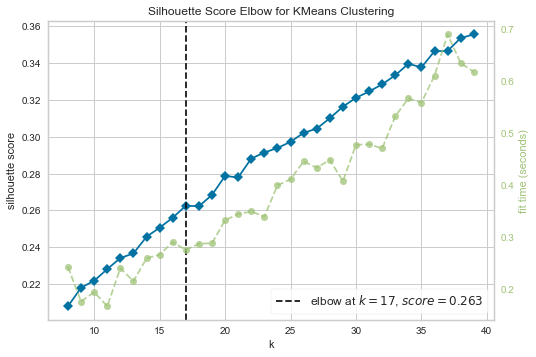

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
# select second elbow
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=7777)
visualizer = KElbowVisualizer(model, k=(8,40), metric="silhouette")
visualizer.fit(tfidf_matrix)
visualizer.show()

In [14]:
model = KMeans(n_clusters=20, random_state=7777)
cluster_res = model.fit_predict(tfidf_matrix)
for idx, res in enumerate(cluster_res):
    label[unknown_label[idx]] = res

In [15]:
mapping = dict()
index = 20
for key in PRODUCT_WORD.keys():
    mapping[key] = index
    index += 1
for idx, cat in enumerate(label):
    if isinstance(cat, str):
        label[idx] = mapping[cat]
metadata_processed['category'] = pd.Series(label)
print(len(label), len(metadata_processed))
print(metadata_processed['text_data'].isnull().sum())

31901 31901
0


In [16]:
print(metadata_processed['category'].value_counts())
print(mapping)

2.0     7783
21.0    3186
24.0    1627
22.0    1028
29.0     896
38.0     851
26.0     831
27.0     737
20.0     695
40.0     637
25.0     619
41.0     611
34.0     594
44.0     534
9.0      495
23.0     476
31.0     474
15.0     451
46.0     424
33.0     397
5.0      388
13.0     376
51.0     364
47.0     346
19.0     341
30.0     319
54.0     290
0.0      275
17.0     257
28.0     255
42.0     252
3.0      237
12.0     232
45.0     232
7.0      231
11.0     229
39.0     215
53.0     214
1.0      192
4.0      189
14.0     186
43.0     171
37.0     171
10.0     167
48.0     165
18.0     164
50.0     155
16.0     155
8.0      153
6.0      146
32.0     137
36.0     137
49.0     126
35.0     105
Name: category, dtype: int64
{'soap': 20, 'hair': 21, 'cream': 22, 'shampoo': 23, 'nail': 24, 'brush': 25, 'lip': 26, 'fragrance': 27, 'vitamin': 28, 'spray': 29, 'ring': 30, 'clean': 31, 'nose': 32, 'jewelry': 33, 'powder': 34, 'razor': 35, 'shave': 36, 'acid': 37, 'eye': 38, 'ear': 39, 'moisture

In [17]:
for i in range(21):
    tf_dict = dict()
    for idx, sent in enumerate(title_without_brand):
        if label[idx]==i:
            title = list()
            for word in sent:
                if  (not((word.norm_ in stop_word) or (word.is_punct) or (word.is_digit))) and len(word)>=2:
                    title.append(word.norm_)
            gram = [' '.join(item) for item in list(ngrams(title, 1))]
            tf_dict = count_tf(gram, tf_dict)
    tf_dict = sorted(tf_dict.items(), key=lambda value:value[1], reverse=True)
    print(f'cluster {i}: ')
    print(tf_dict[:40])
    print('='*50)

cluster 0: 
[('bag', 503), ('cosmetic', 98), ('tote', 60), ('travel', 48), ('toiletry', 44), ('zipper', 34), ('makeup', 34), ('women', 32), ('pouch', 31), ('organizer', 30), ('storage', 30), ('purse', 28), ('teacher', 28), ('shoulder', 26), ('large', 26), ('handbag', 24), ('pocket', 23), ('hanging', 23), ('portable', 21), ('waterproof', 21), ('bags', 20), ('design', 20), ('pockets', 19), ('inches', 19), ('leather', 19), ('easy', 17), ('zip', 17), ('nylon', 16), ('print', 16), ('\t\n', 16), ('small', 15), ('material', 15), ('carry', 15), ('features', 14), ('strap', 14), ('tube', 14), ('cosmetics', 14), ('pink', 14), ('smartwatch', 14), ('closure', 13)]
cluster 1: 
[('essential', 352), ('pure', 85), ('aromatherapy', 44), ('information', 43), ('therapeutic', 43), ('lavender', 39), ('grade', 38), ('aroma', 35), ('bottles', 33), ('medical', 30), ('available', 29), ('skin', 28), ('website', 26), ('professional', 25), ('organic', 23), ('nukira', 23), ('breast', 20), ('scent', 20), ('glass', 1

In [18]:
def transform(data):
    res = dict()
    for item, row in data.iterrows():
        res[row['asin']] = row['category']
    return res

def construct(data):
    if cluster_dict.get(data):
        return cluster_dict[data]
    else:
        return 60.0
metadata_processed['category'] = pd.Series(label)
cluster_dict = transform(metadata_processed)
ratings['category'] = ratings['asin'].apply(construct)

In [19]:
print(ratings['category'].value_counts())

2.0     85337
60.0    35494
21.0    32462
28.0    15923
24.0    14761
22.0    12666
26.0    11920
23.0     7829
29.0     7403
38.0     6957
27.0     6864
46.0     6396
25.0     6257
40.0     5713
20.0     5698
41.0     5682
51.0     5258
44.0     5052
5.0      4764
9.0      4524
15.0     4179
31.0     4054
34.0     3993
30.0     3812
16.0     3718
47.0     3539
54.0     3305
42.0     3275
33.0     3108
13.0     2831
12.0     2677
45.0     2462
36.0     2438
17.0     2436
4.0      2411
7.0      2409
53.0     2363
19.0     2240
1.0      2165
35.0     2005
3.0      1847
11.0     1791
43.0     1760
37.0     1449
18.0     1331
6.0      1276
14.0     1260
32.0     1258
39.0     1231
10.0     1211
50.0     1116
48.0     1023
49.0      989
8.0       936
Name: category, dtype: int64


## 資料切分

In [20]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 產生推薦

In [54]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, KNNWithMeans

def my_recommender(training_data, users, time, category, k=10, user_based=False, algo=KNNBasic):

    training_data = training_data[
        (training_data['DATE']>=time)&
        (training_data['overall']>=4)&
        (training_data['category'].isin(category))
    ]
    cold_start = training_data['asin'].value_counts().sort_values(ascending=False).keys()[:k].to_list()
    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )
    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'pearson',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    count = 0
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            try:
                iid = algo_impl.trainset.to_inner_iid(item)
                recommend_items_iid = algo_impl.get_neighbors(iid, k)
                for sim_item_iid in recommend_items_iid:
                    item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                    if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                        recommend_item_list.append(item_raw_id)
                        recommend_item_set.add(item_raw_id)

                if len(recommend_item_list) >= k:
                    recommend_item_list = recommend_item_list[:k]
                    break
            except:
                pass
        if len(recommend_item_list) == 0:
            recommendation[user] = cold_start
        else:
            recommendation[user] = recommend_item_list
            count += 1
    print(f'recommand {count} person with surprise.')
    return recommendation

def recommender(training_data, users, time, category, k=10, user_based=False, algo=KNNBasic):
    training_data = training_data[
        (training_data['DATE']>=time)&
        (training_data['overall']>=4)&
        (training_data['category'].isin(category))
    ]
    cold_start = training_data['asin'].value_counts().sort_values(ascending=False).keys()[:k].to_list()
    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )
    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        if len(recommend_item_list) == 0:
            recommendation[user] = cold_start
        else:
            recommendation[user] = recommend_item_list

    return recommendation

## 結果評估

## baseline

In [39]:
def evaluate(ratings_testings_by_user, ratings_by_user, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
    score = total / len(ratings_testings)
    return score

time_list = ['2018-07-01','2018-05-01', '2018-01-01', '2016-01-01']
category = [2, 26, 28]
score_list = list()
for time in time_list:
    ratings_by_user = recommender(ratings_trainings, users, time, category, k=10, user_based=False, algo=KNNBasic)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    score_list.append(score)
for idx, time in enumerate(time_list):
    print(f'{time}, score: {score_list[idx]}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
2018-07-01, score: 0.15593220338983052
2018-05-01, score: 0.1440677966101695
2018-01-01, score: 0.11186440677966102
2016-01-01, score: 0.09830508474576272


## method 1

In [55]:
time_list = ['2018-07-01','2018-05-01', '2018-01-01', '2016-01-01']
category = [2, 26, 28]
score_list = list()
for time in time_list:
    ratings_by_user = my_recommender(ratings_trainings, users, time, category, k=10, user_based=True, algo=KNNWithMeans)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    score_list.append(score)
for idx, time in enumerate(time_list):
    print(f'{time}, score: {score_list[idx]}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 2 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 4 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 4 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 11 person with surprise.
2018-07-01, score: 0.15593220338983052
2018-05-01, score: 0.1440677966101695
2018-01-01, score: 0.11186440677966102
2016-01-01, score: 0.09830508474576272


In [56]:
for time in time_list:
    ratings_by_user = my_recommender(ratings_trainings, users, time, category, k=10, user_based=False, algo=KNNWithMeans)
    score = evaluate(ratings_testings_by_user, ratings_by_user)
    score_list.append(score)
for idx, time in enumerate(time_list):
    print(f'{time}, score: {score_list[idx]}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 2 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 4 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 4 person with surprise.
Computing the pearson similarity matrix...
Done computing similarity matrix.
recommand 11 person with surprise.
2018-07-01, score: 0.15593220338983052
2018-05-01, score: 0.1440677966101695
2018-01-01, score: 0.11186440677966102
2016-01-01, score: 0.09830508474576272
